# 데이터셋 분석 및 모델 생성 코드 분석

## 전체 내용 요약

본 문서는 병 판별 프로젝트를 위해 받은 데이터셋을 분석하여 커스텀에 필요한 데이터로 재가공하는 과정과, 커스텀 모델 제작 과정에 관한 코드를 모아 놓은 보고서입니다. 

## 목차

1. 데이터셋 분석
    - 원본 데이터셋 분석 (+ 커스텀 데이터셋 변환)
    - 데이터셋 라벨 분류
2. 데이터모델 분석
    - 커스텀 모델 설계
        - 공통목표
        - 1단계 (간단한 CNN 모델 테스트)
        - 2단계 (복잡한 모델로 업그레이드)
        - 3단계 (yolov5 커스텀 모델 학습)
3. 결론 및 소감

### 1. 데이터셋 분석

#### 커스텀 모델 데이터셋

- 링크 : https://aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&dataSetSn=71385
- AI-Hub의 생활 폐기물 이미지 데이터 원본 551,562장 중에서, 원본 이미지와 함께 있는 JSON 파일의 태그를 활용하여 병 이미지가 있는 이미지를 1차 판별하고, 그 중에서 JSON 파일만 있거나 사진만 있는 파일들을 솎아내는 2차 판별을 시행하여, 총 72,000장의 병 이미지를 분류했습니다.
- 분류된 이미지들을 데이터셋의 JSON label에 따라 9종으로 구분하여 각 폴더에 담은 뒤, 각 이미지를 JSON의 BBOX 좌표를 활용하여 병이 있는 부분을 잘라낸 뒤, 잘라낸 이미지를 224x224 크기로 변환하여, 예시를 위해 각 100장씩을 sample_data 폴더에 담아 놓았었습니다.
- (1차 수정) 커스텀 모델의 학습 과정 진행 중 데이터셋의 이미지 중에 정확도를 방해하는 이미지들이 많아서, 이미지들 중 병 1개만 존재하는 이미지들만 우선 구분하기 위해, 어두운 이미지들을 밝게 처리하고, 노이즈가 낀 사진의 노이즈를 제거하여, 병의 색깔(갈색/녹색/투명)을 구분하기 위한 처리를 하는 것으로 계획을 수정했습니다.

#### 데이터셋 라벨 분류

- 데이터셋의 JSON 라벨은 다음과 같이 9종류로 분류되어 있었고, 라벨의 정확한 분류는 다음과 같습니다.

|JSON 라벨|실제 라벨|
|------|---|
|c_4_01_01|재사용 유리 + 다중포장재|
|c_4_01_02|재사용 유리(소주병+맥주병)|
|c_4_02_01_01|갈색 유리 + 다중포장재|
|c_4_02_01_02|갈색 유리|
|c_4_02_02_01|녹색 유리 + 다중포장재|
|c_4_02_02_02|녹색 유리|
|c_4_02_03_01|백색 유리 + 다중포장재|
|c_4_02_03_02|백색 유리|
|c_4_03|기타 유리|

### 2. 데이터모델 분석 및 설계

#### 커스텀 모델 설계

공통적으로 모든 모델은 x값으로 이미지를 받으며, 각 모델별로 반환하는 y값은 각 단계별로 적을 예정. 모든 모델은 pytorch를 활용해서, cuda 환경을 설치하여(RTX 2070 - CUDA 11.2 - cudnn 8.1.0) 훈련했습니다.

#### 1단계. cnn으로 데이터셋 라벨 기준에 따라 병 종류(색깔)를 파악하여, 색깔과 bbox값을 반환하도록 하기. 

In [8]:
# 패키지 다운로드
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets

# CUDA 지원 활성화
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA 사용 가능")
else:
    device = torch.device("cpu")
    print("CUDA 사용 불가")

# 시드 고정
seed = 42
torch.manual_seed(seed)
# GPU 절약
torch.backends.cudnn.benchmark = True

# print(torch.cuda.device_count()) # 사용 가능한 장치가 몇 개인지 확인합니다.
# print(torch.cuda.get_device_name(0)) # 첫번째 GPU의 장치명을 확인합니다.
# print(torch.cuda.get_device_name(1)) # 두번째 GPU의 장치명을 확인합니다.


CUDA 사용 가능


In [9]:
# 이미지 라벨 생성
def get_label_from_foldername(foldername):
    # 각 폴더의 이름에 따라 라벨을 할당
    if foldername == "preprocessed_brown_glass":
        return "0"
    elif foldername == "preprocessed_brown_glass_packaging":
        return "1"
    elif foldername == "preprocessed_clear_glass":
        return "2"
    elif foldername == "preprocessed_clear_glass_packaging":
        return "3"
    elif foldername == "preprocessed_green_glass":
        return "4"
    elif foldername == "preprocessed_green_glass_packaging":
        return "5"
    elif foldername == "preprocessed_reused_glass":
        return "6"
    elif foldername == "preprocessed_reused_glass_packaging":
        return "7"
    elif foldername == "preprocessed_unclassified_glass":
        return "8"
    else:
        raise ValueError(f"Invalid folder name: {foldername}")

In [10]:
# 데이터셋 경로
dataset_path = "preprocessed_image"

# 데이터셋 불러오기
dataset = datasets.ImageFolder(
    dataset_path,
    # 데이터 증강을 위한 변환 함수들 정의
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # 이미지 크기 조정
        # transforms.RandomResizedCrop(size=224),  # 무작위로 잘라내고 크기 조정
        transforms.RandomHorizontalFlip(),  # 수평으로 무작위로 뒤집기
        transforms.RandomRotation(degrees=30),  # 무작위로 회전 (±30도 범위)
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # 색감 조정
        transforms.ToTensor(),  # 이미지를 텐서로 변환
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # 이미지 정규화
    ])
)

# 전체 데이터셋을 훈련 데이터와 검증 데이터로 나누기
train_ratio = 0.8
train_size = int(train_ratio * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# 데이터로더 생성
batch_size = 4
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

In [11]:
# 모델 레이어 생성
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv0 = nn.Conv2d(3, 3, kernel_size=1)  
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3)
        self.pool = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32 * 111 * 111, 64)
        self.fc2 = nn.Linear(64, 9)  # 클래스 수에 맞게 계속 수정
        
    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.flatten(x)
        x = nn.functional.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x.to(device)

# 모델 인스턴스 생성 및 CUDA 장치로 이동
model = Model().to(device)

In [12]:
print(model)
print(device)

Model(
  (conv0): Conv2d(3, 3, kernel_size=(1, 1), stride=(1, 1))
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=394272, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=9, bias=True)
)
cuda


In [13]:
# 모델 학습시키기
# 손실 함수와 최적화 알고리즘 설정
criterion = nn.CrossEntropyLoss().to(device)  # 손실 함수 수정
optimizer = optim.Adam(model.parameters(), lr=0.003)

# 학습 반복
epochs = 10
best_accuracy = 0.0  # 가장 좋은 정확도를 저장할 변수 초기화
best_model_path = "best_model.pt" # 가장 좋은 모델 매개변수의 저장 경로
full_model_path = "full_model.pt" # 모델 전체를 저장할 경로 

for epoch in range(epochs):
    running_loss = 0.0
    for images, labels in train_dataloader:
        # 이미지와 라벨을 CUDA 장치로 이동
        images = images.to(device)
        labels = labels.to(device)
        # 그래디언트 초기화
        optimizer.zero_grad()
        # 모델에 이미지 전달하여 예측 수행
        outputs = model(images)
        # 손실 계산
        loss = criterion(outputs, labels)

        # # 가중치 감소 (L2 규제)
        # for param in model.parameters():
        #     loss += 0.001 * torch.norm(param)

        # 역전파 및 가중치 업데이트
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1} - Loss: {running_loss / len(train_dataloader)}")


Epoch 1 - Loss: 2.2335100510743433
Epoch 2 - Loss: 2.23347408177268
Epoch 3 - Loss: 2.233474081620719
Epoch 4 - Loss: 2.2334740818366634
Epoch 5 - Loss: 2.233474081748686
Epoch 6 - Loss: 2.233474081764682
Epoch 7 - Loss: 2.233474081716694
Epoch 8 - Loss: 2.2334740817006984
Epoch 9 - Loss: 2.233474081852659
Epoch 10 - Loss: 2.2334740817886756


In [14]:
# 검증 데이터셋을 통한 모델 평가
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in val_dataloader:
        # 이미지와 라벨을 CUDA 장치로 이동
        images = images.to(device)
        labels = labels.to(device)

        # 모델에 이미지 전달하여 예측 수행
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)  # 예측 수정

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy}%")
    
    # 가장 좋은 정확도를 가진 모델 저장
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(model, full_model_path)
        torch.save(model.state_dict(), best_model_path)
        print("Best model saved.")

Test Accuracy: 13.968466957396847%
Best model saved.


##### 1단계 요약

간단한 모델과, 이미지 전처리 과정에서 원본 이미지가 너무 어둡고, 병 이미지가 난잡하게 퍼져 있어, 정확도를 높히는 데 어려움이 있었습니다. 또한 모델을 얹는 과정에서 레이어에 넣는 이미지 크기가 달라지면서 인식률이 떨어지는 문제 또한 존재했습니다.

#### 2단계. 이미지 전처리 방식을 추가하고, 간단한 cnn 모델보다 더 큰 모델(Alexnet)을 사용하여 정확도를 높이기.

더 나은 이미지 전처리를 위해서 https://github.com/danielgatis/rembg 사이트에서 병 뒤의 어두운 배경을 지우는 과정을 수행한 이미지들로 데이터셋을 새로 만들었고, 모델 또한 Alexnet 모델을 빠른 학습을 위해 크기를 1/10로 리사이징한 커스텀 모델을 사용하기로 하였습니다. 이미지 전처리 과정은 [깃허브 링크](https://github.com/KimSangWook57/Bottle_Project_DA/blob/main/notebooks/Image_Preprocessing.ipynb)에 과정을 올려 두었으니 참고하시기 바랍니다.

In [ ]:
# 패키지 다운로드
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets

# CUDA 지원 활성화
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA 사용 가능")
else:
    device = torch.device("cpu")
    print("CUDA 사용 불가")

# CUDA 비활성화 코드
# device = torch.device("cpu")

# 시드 고정
seed = 42
torch.manual_seed(seed)
# GPU 절약
torch.backends.cudnn.benchmark = True

# print(torch.cuda.device_count()) # 사용 가능한 장치가 몇 개인지 확인합니다.
# print(torch.cuda.get_device_name(0)) # 첫번째 GPU의 장치명을 확인합니다.
# print(torch.cuda.get_device_name(1)) # 두번째 GPU의 장치명을 확인합니다.


CUDA 사용 가능


In [ ]:
# 데이터셋 경로
dataset_path = "preprocessed_bottle_images"
# 데이터 폴더 밑에 "brown_bottle", "clear_bottle", "green_bottle" 폴더가 있고, 그 밑에 각 사진들이 존재

# 데이터셋 불러오기
dataset = datasets.ImageFolder(
    dataset_path,
    # 데이터 증강을 위한 변환 함수들 정의
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # 이미지 크기 조정
        # transforms.RandomResizedCrop(size=224),  # 무작위로 잘라내고 크기 조정
        transforms.RandomHorizontalFlip(),  # 수평으로 무작위로 뒤집기
        transforms.RandomRotation(degrees=30),  # 무작위로 회전 (±30도 범위)
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # 색감 조정
        transforms.ToTensor(),  # 이미지를 텐서로 변환
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # 이미지 정규화
    ])
)

# 전체 데이터셋을 훈련 데이터와 검증 데이터로 나누기
train_ratio = 0.8
train_size = int(train_ratio * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# 데이터로더 생성
batch_size = 2
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

In [ ]:
# 모델 레이어 생성
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(3, 96, kernel_size=11, stride=4)
        self.batchnorm1 = nn.BatchNorm2d(96)
        self.pool1 = nn.MaxPool2d(3, 2)
        
        self.conv2 = nn.Conv2d(96, 256, kernel_size=5, padding=2)
        self.batchnorm2 = nn.BatchNorm2d(256)
        self.pool2 = nn.MaxPool2d(3, 2)
        
        self.conv3 = nn.Conv2d(256, 384, kernel_size=3, padding=1)
        self.batchnorm3 = nn.BatchNorm2d(384)
        
        self.conv4 = nn.Conv2d(384, 384, kernel_size=3, padding=1)
        self.batchnorm4 = nn.BatchNorm2d(384)
        
        self.conv5 = nn.Conv2d(384, 256, kernel_size=3, padding=1)
        self.batchnorm5 = nn.BatchNorm2d(256)
        self.pool3 = nn.AdaptiveMaxPool2d((6, 6))
        
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * 6 * 6, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 3)
        
    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = self.batchnorm1(x)
        x = self.pool1(x)
        
        x = nn.functional.relu(self.conv2(x))
        x = self.batchnorm2(x)
        x = self.pool2(x)
        
        x = nn.functional.relu(self.conv3(x))
        x = self.batchnorm3(x)
        
        x = nn.functional.relu(self.conv4(x))
        x = self.batchnorm4(x)
        
        x = nn.functional.relu(self.conv5(x))
        x = self.batchnorm5(x)
        x = self.pool3(x)
        
        x = self.flatten(x)
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x.to(device)

# 모델 인스턴스 생성 및 CUDA 장치로 이동
model = Model().to(device)

In [ ]:
print(model)
print(device)

Model(
  (conv1): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
  (batchnorm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (batchnorm2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm3): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm4): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm5): BatchNorm2d(256, eps=1e-05, momentum=0.1,

In [ ]:
# 모델 학습시키기
# 손실 함수와 최적화 알고리즘 설정
criterion = nn.CrossEntropyLoss().to(device)  # 손실 함수 수정
optimizer = optim.Adam(model.parameters(), lr=0.003, weight_decay=0.001)

# 학습 반복
epochs = 10
best_accuracy = 0.0  # 가장 좋은 정확도를 저장할 변수 초기화
best_model_path = "best_model.pt" # 가장 좋은 모델 매개변수의 저장 경로
prev_loss = None

# 손실 값 저장 리스트 초기화
loss_values = []

for epoch in range(epochs):
    running_loss = 0.0
    for images, labels in train_dataloader:
        # 이미지와 라벨을 CUDA 장치로 이동
        images = images.to(device)
        labels = labels.to(device)
        # 그래디언트 초기화
        optimizer.zero_grad()
        # 모델에 이미지 전달하여 예측 수행
        outputs = model(images)
        # 손실 계산
        loss = criterion(outputs, labels)
        
        # 역전파 및 가중치 업데이트
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1} - Loss: {running_loss / len(train_dataloader)}")

    # Early Stopping 체크
    if prev_loss is not None and running_loss >= prev_loss:
        print("Early stopping due to increasing loss")
        break
    prev_loss = running_loss
  

Epoch 1 - Loss: 1.392205896720364
Epoch 2 - Loss: 0.9067085896188788
Epoch 3 - Loss: 0.7957039289954239
Epoch 4 - Loss: 0.7843154869343821
Epoch 5 - Loss: 0.7706895248350257
Epoch 6 - Loss: 0.7740447817030395
Early stopping due to increasing loss


In [ ]:
# 검증 데이터셋을 통한 모델 평가
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in val_dataloader:
        # 이미지와 라벨을 CUDA 장치로 이동
        images = images.to(device)
        labels = labels.to(device)

        # 모델에 이미지 전달하여 예측 수행
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)  # 예측 수정

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy}%")
    
    # 현재 epoch의 결과가 이전의 가장 좋은 결과보다 좋은 경우, 모델 상태 저장
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(model.state_dict(), best_model_path)
        print("Best model saved.")
        

Test Accuracy: 69.21936758893281%
Best model saved.


- 모델 훈련 시각화 코드 추가 후 돌린 결과

Epoch 1 - Loss: 1.2462296930727044
Validation Accuracy: 36.01778656126482%
Best model saved.
Epoch 2 - Loss: 1.0791742920639957
Validation Accuracy: 54.19960474308301%
Best model saved.
Epoch 3 - Loss: 0.8196223530929403
Validation Accuracy: 70.25691699604744%
Best model saved.
Epoch 4 - Loss: 0.7242471379386224
Validation Accuracy: 67.24308300395256%
Epoch 5 - Loss: 0.703066749695648
Validation Accuracy: 73.81422924901186%
Best model saved.
Epoch 6 - Loss: 0.7022176644525108
Validation Accuracy: 71.49209486166008%
Epoch 7 - Loss: 0.685440921222468
Validation Accuracy: 72.38142292490119%
Epoch 8 - Loss: 0.6758864282670302
Validation Accuracy: 73.17193675889328%
Epoch 9 - Loss: 0.67330396999299
Validation Accuracy: 73.91304347826087%
Best model saved.
Epoch 10 - Loss: 0.6738449444800152
Validation Accuracy: 60.22727272727273%


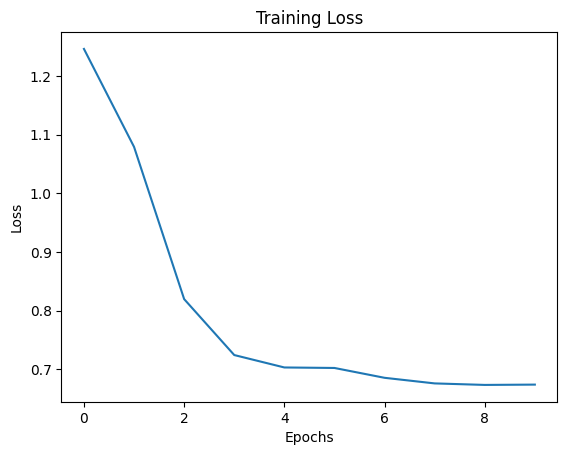

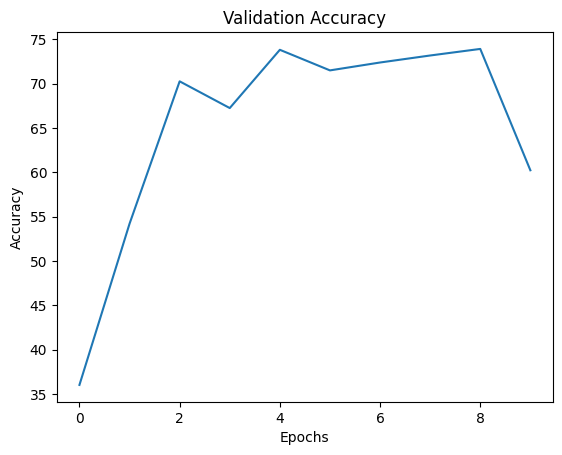

In [ ]:
import matplotlib.pyplot as plt

# 모델 학습시키기
# 손실 함수와 최적화 알고리즘 설정
criterion = nn.CrossEntropyLoss().to(device)  # 손실 함수 수정
optimizer = optim.Adam(model.parameters(), lr=0.003, weight_decay=0.001)

# 학습 반복
epochs = 10
best_accuracy = 0.0  # 가장 좋은 정확도를 저장할 변수 초기화
best_model_path = "best_model.pt" # 가장 좋은 모델 매개변수의 저장 경로
prev_loss = None

# 손실(loss) 및 정확도(accuracy) 기록을 위한 리스트 초기화
loss_values = []
accuracy_values = []

# Early stopping 관련 변수 초기화
early_stopping_count = 0
early_stopping_threshold = 3

# 학습 반복
epochs = 10
best_accuracy = 0.0
best_model_path = "best_model.pt"
prev_loss = None

for epoch in range(epochs):
    running_loss = 0.0
    for images, labels in train_dataloader:
        # 이미지와 라벨을 CUDA 장치로 이동
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    epoch_loss = running_loss / len(train_dataloader)
    loss_values.append(epoch_loss)
    print(f"Epoch {epoch+1} - Loss: {epoch_loss}")

    # 검증 데이터셋을 통한 정확도 계산
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in val_dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_accuracy = 100 * correct / total
        accuracy_values.append(epoch_accuracy)

        print(f"Validation Accuracy: {epoch_accuracy}%")

    # 현재 epoch의 결과가 이전의 가장 좋은 결과보다 좋은 경우, 모델 상태 저장
    if epoch_accuracy > best_accuracy:
        best_accuracy = epoch_accuracy
        torch.save(model.state_dict(), best_model_path)
        print("Best model saved.")

# 손실 그래프
plt.plot(loss_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

# 정확도 그래프
plt.plot(accuracy_values)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.show()

<img src="../screenshots/%EC%BB%A4%EC%8A%A4%ED%85%80%20%EB%AA%A8%EB%8D%B8%20%EA%B2%B0%EA%B3%BC%EA%B0%92%20%EC%98%88%EC%8B%9C_02.PNG">
그림 1. 커스텀 모델을 통해 결과값을 받는 예시로, 가장 높은 양수값을 가지는 클래스를 반환하고 있다.

##### 2단계 요약

판별률이 기존 19%에서 최대 73%까지 상승하여 확연히 좋아졌지만, 실제 병에 대해서는 결과를 제대로 내지 못하는 과적합 문제가 발생했습니다. 하지만 학습을 거의 하지 못하던 cnn 모델에 비해, 적어도 주어진 이미지에 대해서만큼은 유의미한 학습을 시키는 것에 성공했습니다.

#### 3단계. yolov5 커스텀 모델을 위한 데이터셋을 만들어서 학습시켜 보기.

앞의 두 예시를 통해 기존의 좋은 모델을 사용하여 학습을 시켜야 할 필요성을 느꼈기에, 제가 직접 커스텀 모델 레이어를 하나하나씩 쌓아서 모델을 만드는 것은 너무 시간이 많이 걸릴 것으로 판단되어, 기존의 물체 판별 모델인 yolov5를 유리병의 색깔(투명/갈색/녹색)을 판별하는 데 특화시키도록 커스텀한 모델을 만들어 보기로 하였고, 이를 위해 라벨링 프로그램들을 활용하여 파일에 라벨을 매기는 작업을 실행하였습니다.

##### Case 1. labelimg 프로그램 사용.

yolov5 모델 라벨링을 위한 간단한 프로그램 중 하나인 [labelimg](https://github.com/heartexlabs/labelImg)라는 프로그램을 다운받아서 사용해 보았습니다. 

<img src="../screenshots/labelimg%20%EC%82%AC%EC%9A%A9%20%EC%98%88%EC%8B%9C_01.PNG"> \
그림 1. labelimg 이미지 라벨링 작업 과정

<img src="../screenshots/yolov5%20%EC%BB%A4%EC%8A%A4%ED%85%80%20%EB%AA%A8%EB%8D%B8%20%ED%95%99%EC%8A%B5%20%EC%98%88%EC%8B%9C_01.PNG">
그림 2. yolov5 모델 학습 과정

<img src="../screenshots/yolov5%20%EC%BB%A4%EC%8A%A4%ED%85%80%20%EB%AA%A8%EB%8D%B8%20%EB%AC%B8%EC%A0%9C%EC%A0%90%20%EC%98%88%EC%8B%9C_01.PNG" width="50%" height="50%"> \
그림 3. 모델 학습 결과 예시. bbox가 제대로 학습되지 않았다.

##### Case 1의 문제점

프로그램으로 bbox를 제대로 그렸음에도 불구하고, 실제로 학습을 시키자 bbox 값이 어긋나서 학습에 실패하였습니다. 따라서 새로운 이미지 라벨링 툴을 사용할 필요성이 생겼습니다.

##### Case 2. roboflow 사이트 사용.

[roboflow](https://app.roboflow.com/) 사이트에서 라벨링 작업을 지원해서, 사이트에서 라벨링 작업을 진행했습니다. 학습을 위해 작업한 데이터셋은 [여기](https://universe.roboflow.com/project-rfxjh/bottle-c8pb4/dataset/2)에서 확인하실 수 있습니다.

<img src="../screenshots/yolov5%20roboflow%20labeling%20%ED%95%99%EC%8A%B5%20%EC%98%88%EC%8B%9C_01.PNG"> \
그림 1. roboflow 이미지 라벨링 작업 과정

<img src="../screenshots/yolov5%20%EC%BB%A4%EC%8A%A4%ED%85%80%20%EB%AA%A8%EB%8D%B8%20%ED%95%99%EC%8A%B5%20%EC%98%88%EC%8B%9C_03.PNG" width="50%" height="50%"> \
그림 2. 모델 학습 결과 예시. 라벨링한 형태를 거의 대부분 잘 인식함

<img src="../screenshots/yolov5%20%EC%BB%A4%EC%8A%A4%ED%85%80%20%EB%AA%A8%EB%8D%B8%20%ED%8C%90%EB%B3%84%20%EC%98%88%EC%8B%9C_01.PNG" width="50%" height="50%"> \
그림 3. 실제 이미지 인식 결과를 창으로 띄우는 예시

##### 3단계 요약 및 보완점

커스텀 모델을 개발하는 데 성공했지만, 여러 문제점들 또한 발견할 수 있었습니다.

1. 데이터셋을 만들 때 몇몇 이미지는 병의 부분 이미지를 bbox로 정해서 넣었는데, 그 결과 병 하나를 두고 병의 일부분도 병으로 잡아서, 결과적으로 병을 2개 이상 판별해버리는 문제점이 생겼습니다. 이미지 라벨링을 할 때는 굳이 부분 병 이미지를 넣을 필요 없이, 전체 병 이미지만 사용해야 할 것입니다. 하지만 병 일부만 보고도 바로 병을 판별하기는 하므로, 뒤집어 생각하면 병의 일부라도 보고 바로 판별하는 신속함이 필요하다면, 차라리 부분 그 자체에 집중한 이미지들을 학습시키면 될 것입니다.

2. 데이터셋의 이미지들이 비스듬히 세워져 있거나, 누워 있거나, 거꾸로 뒤집힌 모습들이 있는 것은 좋으나, 그러한 이미지들이 너무 많은 관계로, 오히려 정면 이미지에 대한 판별률은 떨어지는 문제가 발생했습니다. 이미지 데이터셋을 만들 때, 변주를 주는 것은 데이터 전처리 중에 데이터 증강 과정을 통해 해결할 수 있으므로, 판별을 위한 제일 기초적인 형태의 이미지가 가장 많이 필요할 것입니다. 물론 이러한 기울어진 병 이미지들을 판별하는 것이 더 중요하다면, 이 이미지셋이 목적에 부합한다고 볼 수 있을 것입니다.

3. 1번과 2번에서 모두 일부분적으로 나타나는 문제인데, yolov5 모델 특성상 비슷한 특성을 여러 개 발견하면 하나의 물체에 여러 개의 bbox를 매기는 문제점이 발생합니다. 따라서 한 번에 하나의 병만 찾으려 한다면, 애매한 분류를 하기보다 특징을 확실하게 잡을 수 있도록 하는 것이 중요하다고 생각됩니다. 예를 들어 상표가 붙어 있는 것과 없는 것을 구분하려고 한다면, 먼저 병 형태를 모두 구분한 뒤, 상표가 붙은 모든 병에서 상표 부분만을 구분하게 할 수 있도록 구현해야 할 것입니다.


### 결론 및 소감

프로젝트 진행을 위해서, 교육 시간에 배운 기초적인 CNN 모델부터, 더욱 복잡한 모델을 만들어서 병 판별에 대한 성능을 올리는 과정을 거쳐, yolov5 custom model 학습까지의 과정을 마무리하면서 느낀 점은, 모델을 직접 만들어 보고 적용하는 과정에서 개발의 어려움과 이미지 전처리의 중요성을 인지하고, yolov5 모델을 커스텀하면서 원하는 목표를 위한 데어터셋과 이미지 전처리 방향을 명확하게 잡아야 한다는 것이었습니다.

결론짓자면, yolov5라는 도구를 제시받아서, 그에 맞춘 데이터셋을 맞추기 위한 지식을 얻을 수 있었다는 점에서 저의 이미지 처리 실력을 높일 수 있었던 프로젝트였다고 생각됩니다. 